In [3]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score



###   iris   ###
column_names = ['X1', 'X2', 'X3', 'X4', 'Cluster']
iris_df = pd.read_csv('iris.csv', header=None, names=column_names)

###   long   ###
with open("long.txt", "r") as file:
    long_df = pd.DataFrame([line.strip().split() for line in file], columns=["X", "Y", "Cluster"])
long_df = long_df.astype({'X': 'float', 'Y': 'float', 'Cluster': 'int'})

###   2d-10c   ###
with open("2d-10c.txt", "r") as file:
    d2_c10_df = pd.DataFrame([line.strip().split() for line in file], columns=["X", "Y", "Cluster"])
d2_c10_df = d2_c10_df.astype({'X': 'float', 'Y': 'float', 'Cluster': 'int'})

###   square   ###
with open("square.txt", "r") as file:
    square_df = pd.DataFrame([line.strip().split() for line in file], columns=["X", "Y", "Cluster"])
square_df = square_df.astype({'X': 'float', 'Y': 'float', 'Cluster': 'int'})

###   Smile   ###
column_names = ['X1', 'X2', 'Cluster']
smile_df = pd.read_csv('smile.csv', header=None, names=column_names)

###   order2-3clust   ###
column_names = ['X1', 'X2', 'Cluster']
order2_3clust_df = pd.read_csv('order2-3clust.csv', header=None, names=column_names)

# Display the first 5 lines of both DataFrames
print("First lines of iris.csv:")
print(iris_df.head(2))
print("\nFirst lines of long.txt:")
print(long_df.head(2))
print("\nFirst lines of 2d-10c.txt:")
print(d2_c10_df.head(2))
print("\nFirst lines of square.txt:")
print(square_df.head(2))
print("\nFirst lines of smile.csv:")
print(smile_df.head(2))
print("\nFirst lines of order2-3clust.csv:")
print(order2_3clust_df.head(2))

# Count the number of clusters in each dataset
print("\nNumber of clusters in iris dataset:", iris_df.iloc[:, -1].nunique())
print("\nNumber of clusters in long dataset:", long_df.iloc[:, -1].nunique())
print("\nNumber of clusters in 2d-10c dataset:", d2_c10_df.iloc[:, -1].nunique())
print("\nNumber of clusters in square dataset:", square_df.iloc[:, -1].nunique())
print("\nNumber of clusters in smile dataset:", smile_df.iloc[:, -1].nunique())
print("\nNumber of clusters in order2-3clust dataset:", order2_3clust_df.iloc[:, -1].nunique())


First lines of iris.csv:
    X1   X2   X3   X4  Cluster
0  5.1  3.5  1.4  0.2        0
1  4.9  3.0  1.4  0.2        0

First lines of long.txt:
          X         Y  Cluster
0  0.167967 -0.171240        0
1 -1.257550  0.054219        0

First lines of 2d-10c.txt:
           X        Y  Cluster
0  12.757900 -4.81962        0
1  -0.298175 -5.03868        0

First lines of square.txt:
         X        Y  Cluster
0  6.10273  6.28359        0
1  5.46167  8.29113        0

First lines of smile.csv:
         X1        X2  Cluster
0 -0.674245 -0.664492        0
1  0.846659 -0.538960        0

First lines of order2-3clust.csv:
         X1          X2  Cluster
0 -8.804895  104.458572        0
1 -1.409040   37.172486        0

Number of clusters in iris dataset: 3

Number of clusters in long dataset: 2

Number of clusters in 2d-10c dataset: 10

Number of clusters in square dataset: 4

Number of clusters in smile dataset: 4

Number of clusters in order2-3clust dataset: 3


# Functions

In [4]:
def apply_dbscan(df, eps=0.5, min_samples=5):
    features = df.iloc[:, :]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    pred = dbscan.fit_predict(features)
    num_clusters = len(set(pred)) - (1 if -1 in pred else 0)  # Exclude noise points
    num_outliers = list(pred).count(-1)
    num_true_clusters = len(df['Cluster'].unique())
    return pred, f"This {eps} distance and {min_samples} neighbours DBSCAN found {num_clusters} clusters, with {num_outliers} outliers, the dataset has {num_true_clusters} clusters"


def apply_kmeans(df):
    # Separate features and labels
    features = df.iloc[:, :-1]  # All columns except the last one
    labels = df.iloc[:, -1]     # Last column

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=labels.nunique())
    pred = kmeans.fit_predict(features)

    return pred

def apply_link_clustering(df, linkage_type):
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]
    n_clusters = labels.nunique()
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_type)
    pred = clustering.fit_predict(features)
    return pred


def apply_em(df):
    # Separate features and labels
    features = df.iloc[:, :-1]  # All columns except the last one
    labels = df.iloc[:, -1]     # Last column

    # Apply Expectation-Maximization (EM) algorithm
    gmm = GaussianMixture(n_components=labels.nunique())
    pred = gmm.fit_predict(features)

    return pred

def find_best_mapping(df, pred, permutations):
    best_accuracy = 0
    best_mapping = None
   # Iterate through each permutation
    for i, perm in enumerate(permutations):
        unique_tags = df['Cluster'].unique()
        # Create a mapping dictionary from old tags to shuffled tags
        mapping = {old_tag: new_tag for old_tag, new_tag in zip(unique_tags, perm)}
        
        # Replace cluster tags in a copy of the dataset with shuffled tags
        shuffled_df = df.copy()
        shuffled_df['Cluster'] = shuffled_df['Cluster'].map(mapping)
        
        # Calculate accuracy for iris dataset using K-means clustering
        accuracy = accuracy_score(shuffled_df['Cluster'], pred)
        
        # Check if the new accuracy is better than the best accuracy so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping
    
    return best_accuracy, best_mapping

def get_best_map_accuracy(df, pred):
    unique_tags = df['Cluster'].unique()
    permutations = list(itertools.permutations(unique_tags))
    best_accuracy, best_mapping = find_best_mapping(df, pred, permutations)
    return best_mapping, best_accuracy

def plot_instances_by_truth(dataset, folder_name, method_name):
    x = dataset.iloc[:, 0]
    y = dataset.iloc[:, 1]
    clusters = dataset.iloc[:, 2]
    unique_clusters = clusters.unique()

    # Plot each cluster with a different color
    plt.figure(figsize=(8, 6))
    for cluster_label in unique_clusters:
        cluster_points = dataset[clusters == cluster_label]
        plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster_label}', alpha=0.5)

    plt.title('Ground truth of instances by cluster')
    plt.grid(True)
    plt.savefig(f"Plots\{folder_name}\{method_name}.png")
    plt.show()

def plot_instances_by_prediction(dataset, prediction, folder_name, method_name):
    x = dataset.iloc[:, 0]
    y = dataset.iloc[:, 1]
    clusters = prediction
    unique_clusters = set(clusters)

    # Plot each cluster with a different color
    plt.figure(figsize=(8, 6))
    for cluster_label in unique_clusters:
        cluster_points = dataset[clusters == cluster_label]
        plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster_label}', alpha=0.5)

    plt.title('Instances by predicted cluster')
    plt.grid(True)
    plt.savefig(f"Plots\{folder_name}\{method_name}.png")
    plt.show()

def plot_instances_with_clusters(dataset, folder_name, method_name):
    custom_palette = ['red', 'green', 'blue']
    sns.pairplot(dataset, hue='Cluster', palette=custom_palette)
    plt.suptitle('Pairwise Relationships in Dataset with Cluster Coloring', y=1.02)
    plt.savefig(f"Plots\{folder_name}\{method_name}.png")
    plt.show()

def plot_instances_with_custom_clusters(dataset, cluster_assignments, folder_name, method_name):
    dataset_copy = dataset.copy()
    dataset_copy['Cluster'] = cluster_assignments

    custom_palette = ['red', 'green', 'blue']
    sns.pairplot(dataset_copy, hue='Cluster', palette=custom_palette)
    plt.suptitle('Pairwise Relationships in Dataset with Custom Cluster Coloring', y=1.02)
    plt.savefig(f"Plots\{folder_name}\{method_name}.png")
    plt.show()



# Ground Truth Plots

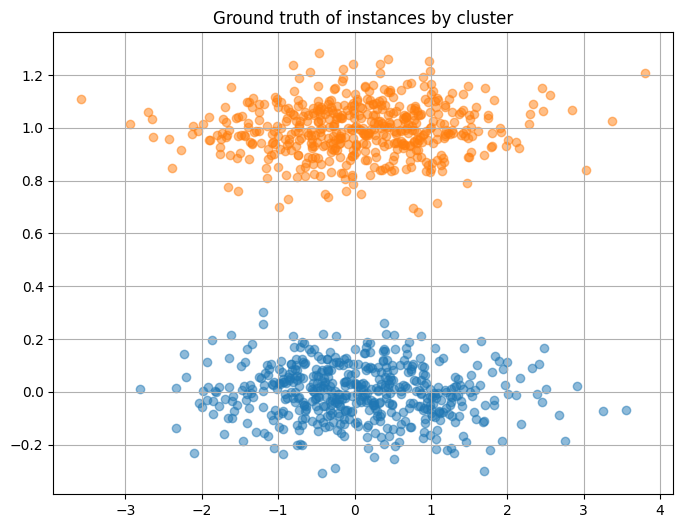

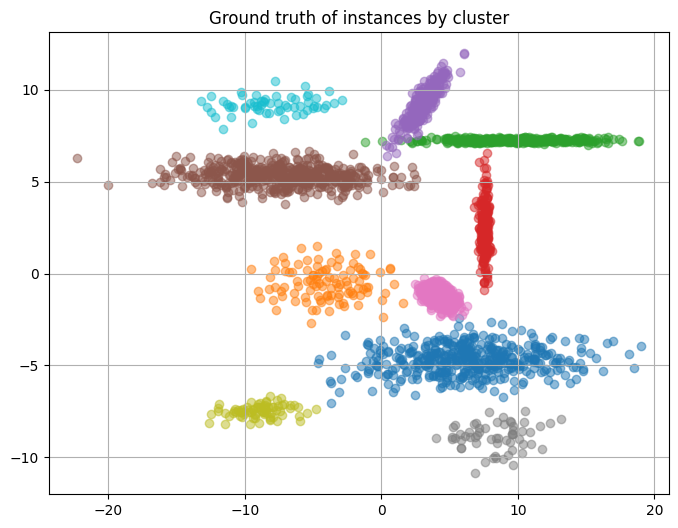

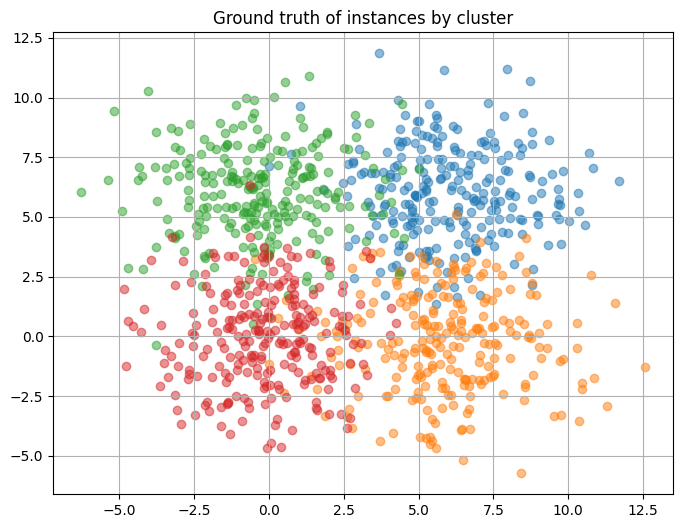

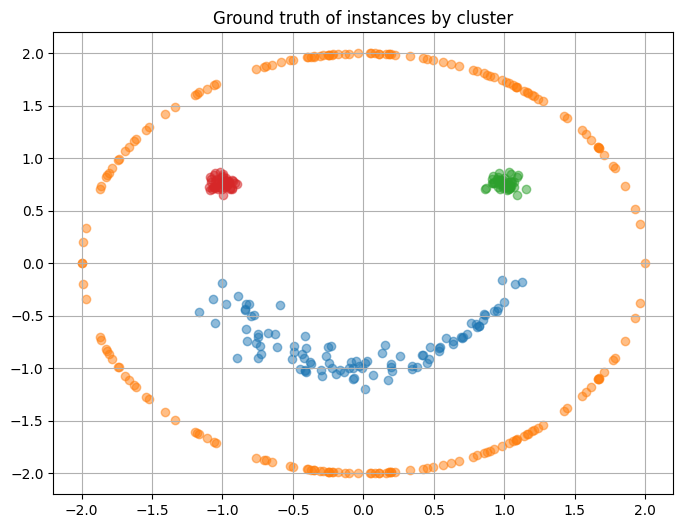

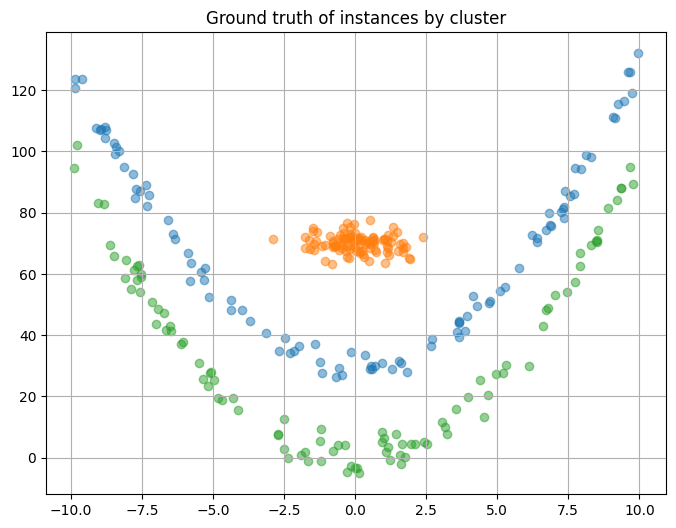

In [5]:
plot_instances_by_truth(long_df, "Long", "Truth")
plot_instances_by_truth(d2_c10_df, "2d_10c", "Truth")
plot_instances_by_truth(square_df, "Square", "Truth")
plot_instances_by_truth(smile_df, "Smile", "Truth")
plot_instances_by_truth(order2_3clust_df, "order2_3clust", "Truth")

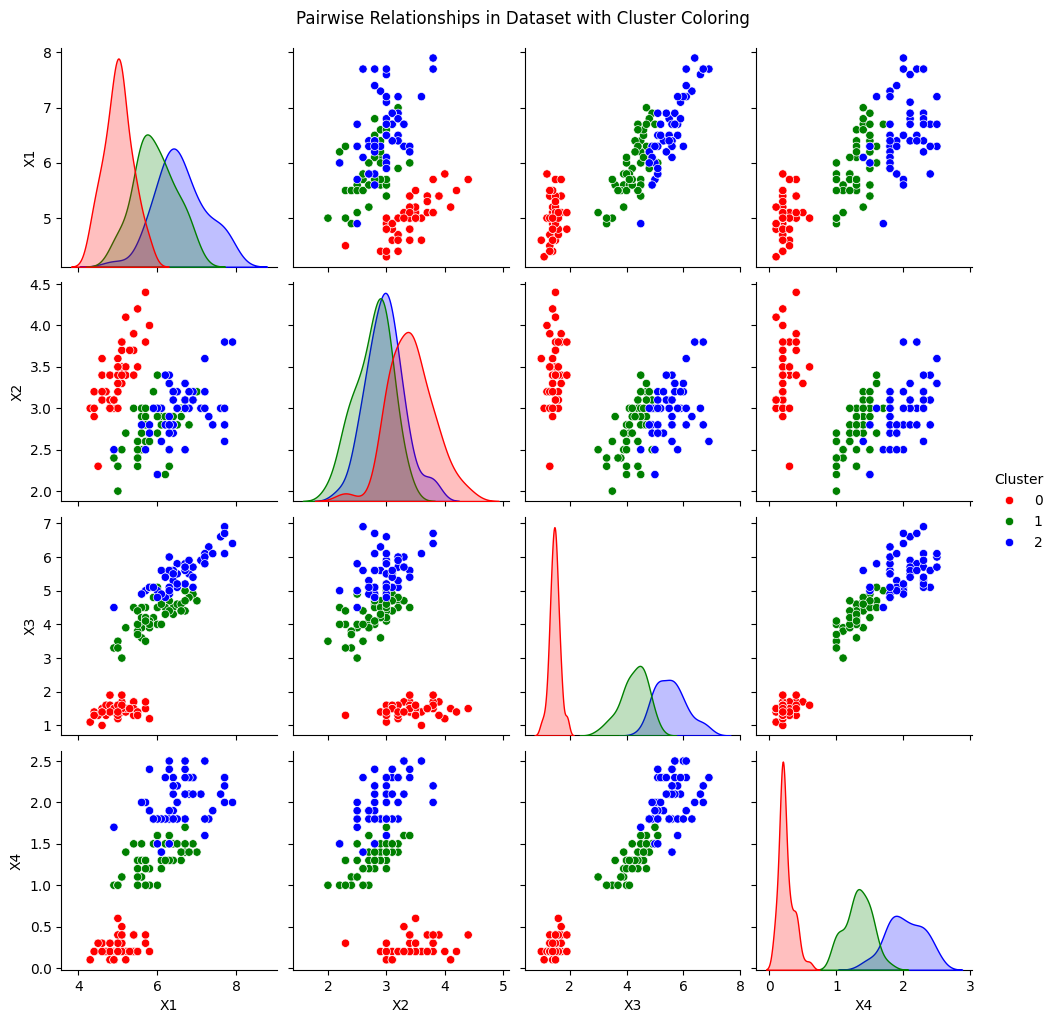

In [6]:
plot_instances_with_clusters(iris_df, "Iris", "Truth")

# Long

In [7]:
print("K-means")
#while(1):
long_pred_kmeans = apply_kmeans(long_df)
#    if long_pred[0] == long_pred[1]:
#        break
long_map_acc = get_best_map_accuracy(long_df, long_pred_kmeans)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

K-means
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.507


In [8]:
print("EM")
long_pred_em = apply_em(long_df)
long_map_acc = get_best_map_accuracy(long_df, long_pred_em)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

EM
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.564


In [9]:
print("Single-Link")
long_pred_sl = apply_link_clustering(long_df, "single")
long_map_acc = get_best_map_accuracy(long_df, long_pred_sl)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

Single-Link
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.501


In [10]:
print("Complete-Link")
long_pred_cl = apply_link_clustering(long_df, "complete")
long_map_acc = get_best_map_accuracy(long_df, long_pred_cl)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

Complete-Link
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.55


In [11]:
print("Average-Link")
long_pred_al = apply_link_clustering(long_df, "average")
long_map_acc = get_best_map_accuracy(long_df, long_pred_al)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

Average-Link
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.504


In [12]:
print("Ward Variance")
long_pred_wl = apply_link_clustering(long_df, "ward")
long_map_acc = get_best_map_accuracy(long_df, long_pred_wl)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

Ward Variance
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.517


In [13]:
print("DBSCAN")
long_pred_ds, result = apply_dbscan(long_df, 0.37, 2)
print(result)
long_map_acc = get_best_map_accuracy(long_df, long_pred_ds)
print(f"Best Mapping: {long_map_acc[0]}")
print(f"Best Accuracy: {long_map_acc[1]}")

DBSCAN
This 0.37 distance and 2 neighbours DBSCAN found 2 clusters, with 4 outliers, the dataset has 2 clusters
Best Mapping: {0: 0, 1: 1}
Best Accuracy: 0.996


# Iris

In [14]:
print("K-means")
iris_pred_kmeans = apply_kmeans(iris_df)
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_kmeans)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

K-means
Best Mapping: {0: 1, 1: 0, 2: 2}
Best Accuracy: 0.8866666666666667


In [15]:
print("EM")
iris_pred_em = apply_em(iris_df)
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_em)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

EM
Best Mapping: {0: 1, 1: 0, 2: 2}
Best Accuracy: 0.9666666666666667


In [ ]:
print("Single-Link")
iris_pred_sl = apply_link_clustering(iris_df, "single")
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_sl)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

Single-Link
Best Mapping: {0: 1, 1: 0, 2: 2}
Best Accuracy: 0.68


In [17]:
print("Complete-Link")
iris_pred_cl = apply_link_clustering(iris_df, "complete")
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_cl)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

Complete-Link
Best Mapping: {0: 1, 1: 2, 2: 0}
Best Accuracy: 0.84


In [18]:
print("Average-Link")
iris_pred_al = apply_link_clustering(iris_df, "average")
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_al)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

Average-Link
Best Mapping: {0: 1, 1: 0, 2: 2}
Best Accuracy: 0.9066666666666666


In [19]:
print("Ward Variance")
iris_pred_wl = apply_link_clustering(iris_df, "ward")
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_wl)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

Ward Variance
Best Mapping: {0: 1, 1: 0, 2: 2}
Best Accuracy: 0.8933333333333333


In [20]:
print("DBSCAN")
iris_pred_ds, result = apply_dbscan(iris_df, 0.5, 5)
print(result)
iris_map_acc = get_best_map_accuracy(iris_df, iris_pred_ds)
print(f"Best Mapping: {iris_map_acc[0]}")
print(f"Best Accuracy: {iris_map_acc[1]}")

DBSCAN
This 0.5 distance and 5 neighbours DBSCAN found 3 clusters, with 18 outliers, the dataset has 3 clusters
Best Mapping: {0: 0, 1: 1, 2: 2}
Best Accuracy: 0.88


# 2d-10c

In [21]:
print("K-means")
accuracy = 0
for i in range(10000):
    d2_c10_pred_kmeans = apply_kmeans(d2_c10_df)
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_kmeans)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
print(accuracy)

K-means


KeyboardInterrupt: 

In [ ]:
print("EM")
accuracy = 0
for i in range(10000):
    d2_c10_pred_em = apply_em(d2_c10_df)
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_em)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy

print(accuracy)

EM
0.8403960396039604


In [ ]:
print("Single-Link")
accuracy = 0
for i in range(10000):
    d2_c10_pred_sl = apply_link_clustering(d2_c10_df, "single")
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_sl)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
print(accuracy)

Single-Link
0.16554455445544555


In [ ]:
print("Complete-Link")
accuracy = 0
for i in range(10000):
    d2_c10_pred_cl = apply_link_clustering(d2_c10_df, "single")
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_cl)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
print(accuracy)

Complete-Link
0.16554455445544555


In [ ]:
print("Average-Link")
accuracy = 0
for i in range(10000):
    d2_c10_pred_al = apply_link_clustering(d2_c10_df, "single")
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_al)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
print(accuracy)

Average-Link
0.16554455445544555


In [ ]:
print("Ward Variance")
accuracy = 0
for i in range(10000):
    d2_c10_pred_wl = apply_link_clustering(d2_c10_df, "single")
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_wl)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
print(accuracy)

Ward Variance
0.16554455445544555


In [ ]:
print("DBSCAN")
result = ''
accuracy = 0
for i in range(1000):
    d2_c10_pred_ds, temp_result = apply_dbscan(d2_c10_df, 1.14, 5)
    temp_accuracy = accuracy_score(d2_c10_df['Cluster'], d2_c10_pred_ds)
    if(accuracy < temp_accuracy):
        accuracy = temp_accuracy
        result = temp_result
print(accuracy)
print(result)

DBSCAN
0.9900990099009901
This 1.14 distance and 5 neighbours DBSCAN found 10 clusters, with 25 outliers, the dataset has 10 clusters


# Square

In [ ]:
print("K-means")
square_pred_kmeans = apply_kmeans(square_df)
square_map_acc = get_best_map_accuracy(square_df, square_pred_kmeans)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

K-means
Best Mapping: {0: 0, 1: 2, 2: 3, 3: 1}
Best Accuracy: 0.869


In [ ]:
print("EM")
square_pred_em = apply_em(square_df)
square_map_acc = get_best_map_accuracy(square_df, square_pred_em)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

EM
Best Mapping: {0: 2, 1: 1, 2: 3, 3: 0}
Best Accuracy: 0.868


In [ ]:
print("Single-Link")
square_pred_sl = apply_link_clustering(square_df, "single")
square_map_acc = get_best_map_accuracy(square_df, square_pred_sl)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

Single-Link
Best Mapping: {0: 3, 1: 1, 2: 0, 3: 2}
Best Accuracy: 0.252


In [ ]:
print("Complete-Link")
square_pred_cl = apply_link_clustering(square_df, "complete")
square_map_acc = get_best_map_accuracy(square_df, square_pred_sl)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

Complete-Link
Best Mapping: {0: 3, 1: 1, 2: 0, 3: 2}
Best Accuracy: 0.252


In [ ]:
print("Average-Link")
square_pred_al = apply_link_clustering(square_df, "average")
square_map_acc = get_best_map_accuracy(square_df, square_pred_al)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

Average-Link
Best Mapping: {0: 0, 1: 2, 2: 1, 3: 3}
Best Accuracy: 0.831


In [ ]:
print("Ward Variance")
square_pred_wl = apply_link_clustering(square_df, "ward")
square_map_acc = get_best_map_accuracy(square_df, square_pred_wl)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

Ward Variance
Best Mapping: {0: 0, 1: 3, 2: 2, 3: 1}
Best Accuracy: 0.788


In [ ]:
print("DBSCAN")
square_pred_ds, result = apply_dbscan(square_df, 1, 6)
print(result)
square_map_acc = get_best_map_accuracy(square_df, square_pred_ds)
print(f"Best Mapping: {square_map_acc[0]}")
print(f"Best Accuracy: {square_map_acc[1]}")

DBSCAN
This 1 distance and 6 neighbours DBSCAN found 4 clusters, with 79 outliers, the dataset has 4 clusters
Best Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Best Accuracy: 0.921


# Smile

In [ ]:
print("K-means")
smile_pred_kmeans = apply_kmeans(smile_df)
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_kmeans)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

K-means
Best Mapping: {0: 2, 1: 0, 2: 3, 3: 1}
Best Accuracy: 0.51


In [ ]:
print("EM")
smile_pred_em = apply_em(smile_df)
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_em)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

EM
Best Mapping: {0: 0, 1: 1, 2: 3, 3: 2}
Best Accuracy: 0.535


In [ ]:
print("Single-Link")
smile_pred_sl = apply_link_clustering(smile_df, "single")
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_sl)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

Single-Link
Best Mapping: {0: 1, 1: 0, 2: 3, 3: 2}
Best Accuracy: 1.0


In [ ]:
print("Complete-Link")
smile_pred_cl = apply_link_clustering(smile_df, "complete")
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_cl)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

Complete-Link
Best Mapping: {0: 0, 1: 2, 2: 3, 3: 1}
Best Accuracy: 0.51


In [ ]:
print("Average-Link")
smile_pred_al = apply_link_clustering(smile_df, "average")
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_al)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

Average-Link
Best Mapping: {0: 1, 1: 3, 2: 0, 3: 2}
Best Accuracy: 0.5225


In [ ]:
print("Ward Variance")
smile_pred_wl = apply_link_clustering(smile_df, "ward")
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_wl)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

Ward Variance
Best Mapping: {0: 1, 1: 3, 2: 2, 3: 0}
Best Accuracy: 0.5075


In [ ]:
print("DBSCAN")
smile_pred_ds, result = apply_dbscan(smile_df, 1, 6)
print(result)
smile_map_acc = get_best_map_accuracy(smile_df, smile_pred_ds)
print(f"Best Mapping: {smile_map_acc[0]}")
print(f"Best Accuracy: {smile_map_acc[1]}")

DBSCAN
This 1 distance and 6 neighbours DBSCAN found 4 clusters, with 0 outliers, the dataset has 4 clusters
Best Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Best Accuracy: 1.0


# order2-3clust

In [ ]:
print("K-means")
order2_3clust_pred_kmeans = apply_kmeans(order2_3clust_df)
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_kmeans)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

K-means
Best Mapping: {0: 2, 1: 0, 2: 1}
Best Accuracy: 0.6333333333333333


In [ ]:
print("EM")
order2_3clust_pred_em = apply_em(order2_3clust_df)
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_em)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

EM
Best Mapping: {0: 0, 1: 2, 2: 1}
Best Accuracy: 0.7033333333333334


In [ ]:
print("Single-Link")
order2_3clust_pred_sl = apply_link_clustering(order2_3clust_df, "single")
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_sl)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

Single-Link
Best Mapping: {0: 0, 1: 1, 2: 2}
Best Accuracy: 0.36


In [ ]:
print("Complete-Link")
order2_3clust_pred_cl = apply_link_clustering(order2_3clust_df, "complete")
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_cl)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

Complete-Link
Best Mapping: {0: 0, 1: 2, 2: 1}
Best Accuracy: 0.67


In [ ]:
print("Average-Link")
order2_3clust_pred_al = apply_link_clustering(order2_3clust_df, "average")
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_al)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

Average-Link
Best Mapping: {0: 2, 1: 1, 2: 0}
Best Accuracy: 0.58


In [ ]:
print("Ward Variance")
order2_3clust_pred_wl = apply_link_clustering(order2_3clust_df, "ward")
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_wl)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

Ward Variance
Best Mapping: {0: 1, 1: 2, 2: 0}
Best Accuracy: 0.6833333333333333


In [ ]:
print("DBSCAN")
order2_3clust_pred_ds, result = apply_dbscan(order2_3clust_df, 6, 10)
print(result)
order2_3clust_map_acc = get_best_map_accuracy(order2_3clust_df, order2_3clust_pred_ds)
print(f"Best Mapping: {order2_3clust_map_acc[0]}")
print(f"Best Accuracy: {order2_3clust_map_acc[1]}")

DBSCAN
This 6 distance and 10 neighbours DBSCAN found 3 clusters, with 27 outliers, the dataset has 3 clusters
Best Mapping: {0: 0, 1: 1, 2: 2}
Best Accuracy: 0.49666666666666665


# Plotting

In [ ]:
plot_instances_by_prediction(long_df,long_pred_kmeans, "Long", "Kmeans")
plot_instances_by_prediction(long_df,long_pred_em, "Long", "EM")
plot_instances_by_prediction(long_df,long_pred_sl, "Long", "SingleLink")
plot_instances_by_prediction(long_df,long_pred_cl, "Long", "CompleteLink")
plot_instances_by_prediction(long_df,long_pred_al, "Long", "AverageLink")
plot_instances_by_prediction(long_df,long_pred_wl, "Long", "Ward Variance")
plot_instances_by_prediction(long_df,long_pred_ds, "Long", "DBSCAN")

plot_instances_by_prediction(smile_df,smile_pred_kmeans, "Smile", "Kmeans")
plot_instances_by_prediction(smile_df,smile_pred_em, "Smile", "EM")
plot_instances_by_prediction(smile_df,smile_pred_sl, "Smile", "SingleLink")
plot_instances_by_prediction(smile_df,smile_pred_cl, "Smile", "CompleteLink")
plot_instances_by_prediction(smile_df,smile_pred_al, "Smile", "AverageLink")
plot_instances_by_prediction(smile_df,smile_pred_wl, "Smile", "Ward Variance")
plot_instances_by_prediction(smile_df,smile_pred_ds, "Smile", "DBSCAN")

plot_instances_by_prediction(square_df,square_pred_kmeans, "Square", "Kmeans")
plot_instances_by_prediction(square_df,square_pred_em, "Square", "EM")
plot_instances_by_prediction(square_df,square_pred_sl, "Square", "SingleLink")
plot_instances_by_prediction(square_df,square_pred_cl, "Square", "CompleteLink")
plot_instances_by_prediction(square_df,square_pred_al, "Square", "AverageLink")
plot_instances_by_prediction(square_df,square_pred_wl, "Square", "Ward Variance")
plot_instances_by_prediction(square_df,square_pred_ds, "Square", "DBSCAN")

plot_instances_by_prediction(d2_c10_df,d2_c10_pred_kmeans, "2d_10c", "Kmeans")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_em, "2d_10c", "EM")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_sl, "2d_10c", "SingleLink")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_cl, "2d_10c", "CompleteLink")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_al, "2d_10c", "AverageLink")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_wl, "2d_10c", "Ward Variance")
plot_instances_by_prediction(d2_c10_df,d2_c10_pred_ds, "2d_10c", "DBSCAN")

plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_kmeans, "order2_3clust", "Kmeans")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_em, "order2_3clust", "EM")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_sl, "order2_3clust", "SingleLink")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_cl, "order2_3clust", "CompleteLink")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_al, "order2_3clust", "AverageLink")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_wl, "order2_3clust", "Ward Variance")
plot_instances_by_prediction(order2_3clust_df,order2_3clust_pred_ds, "order2_3clust", "DBSCAN")

NameError: name 'long_df' is not defined

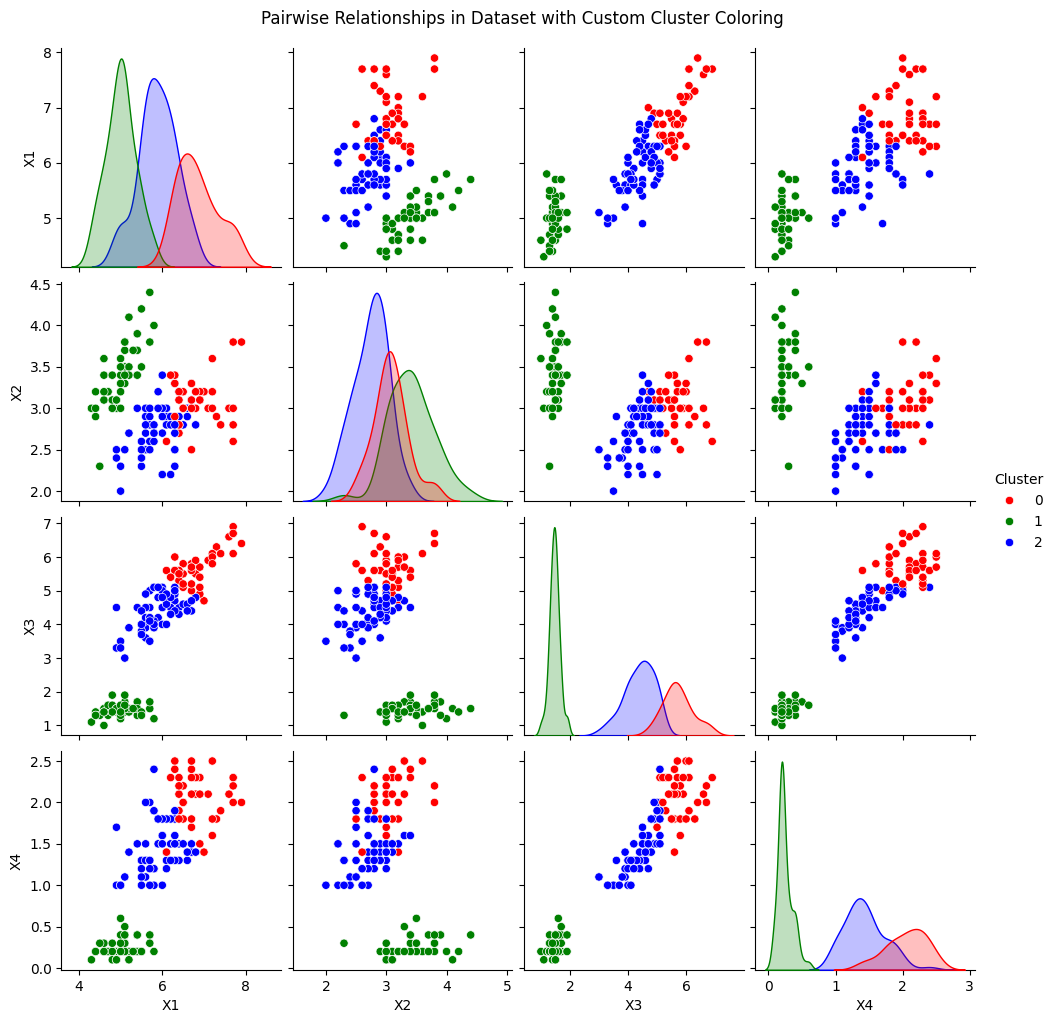

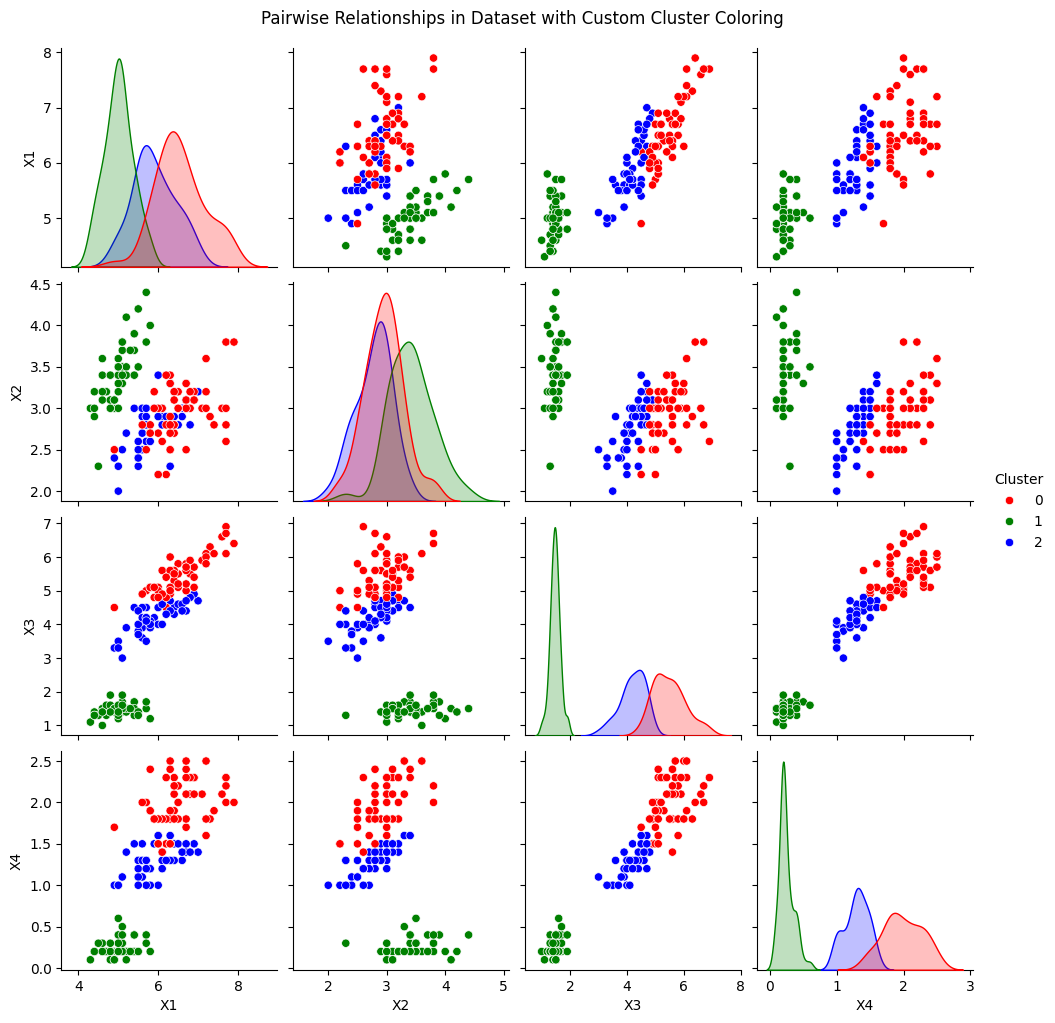

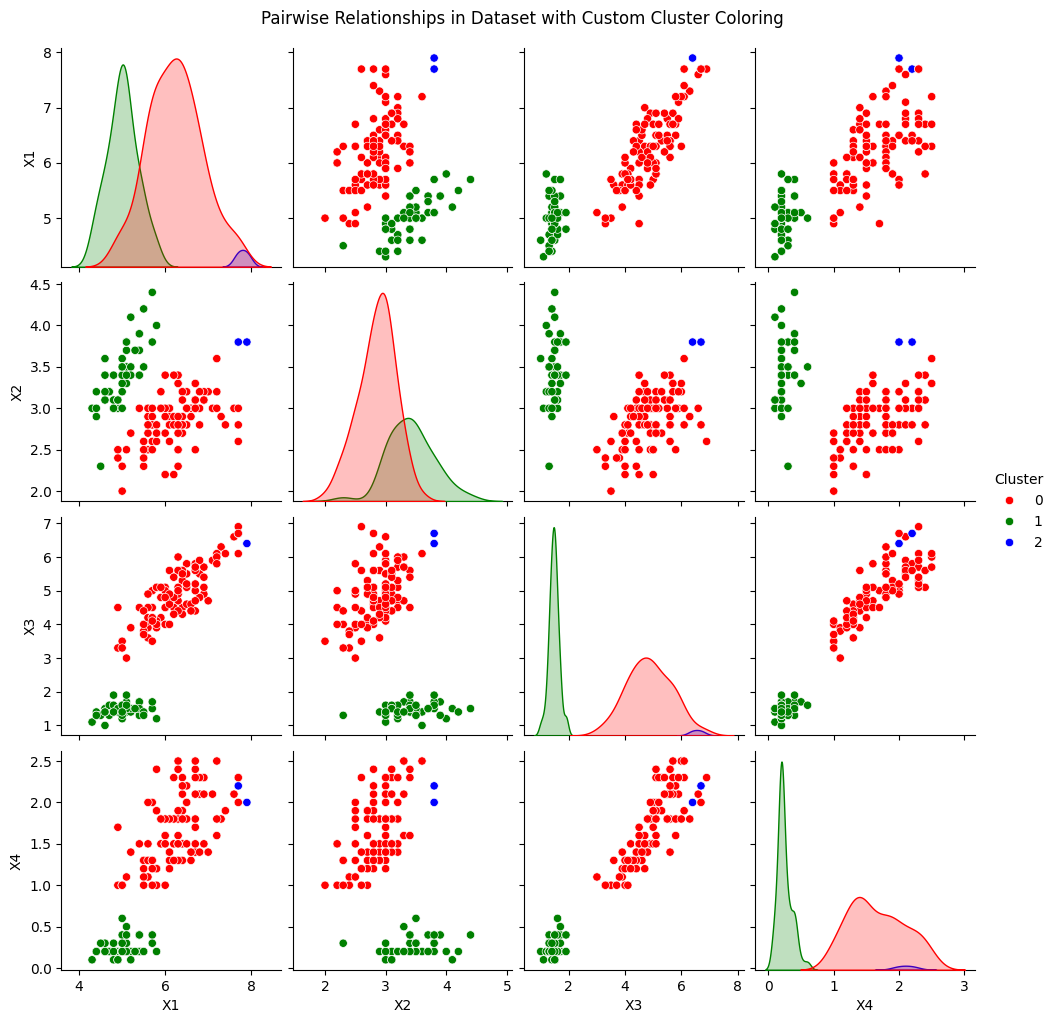

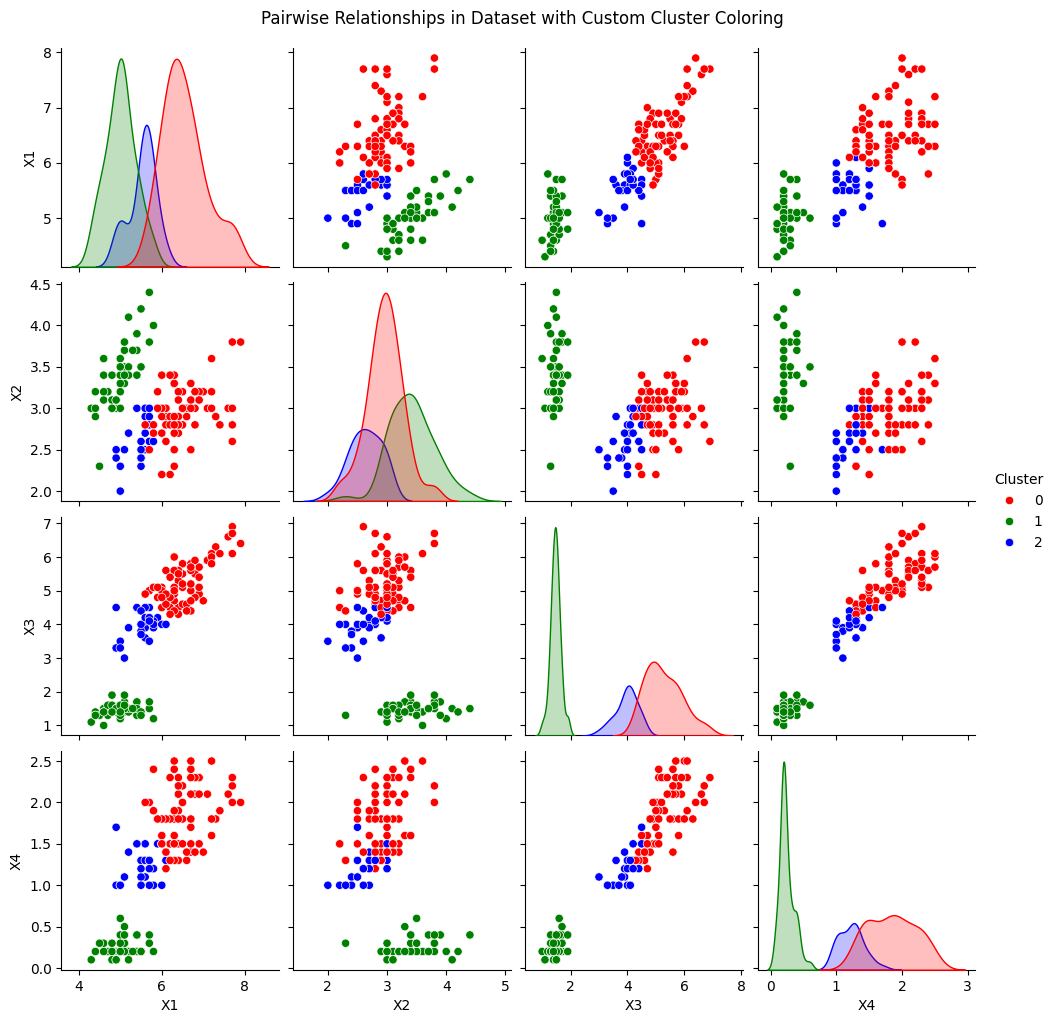

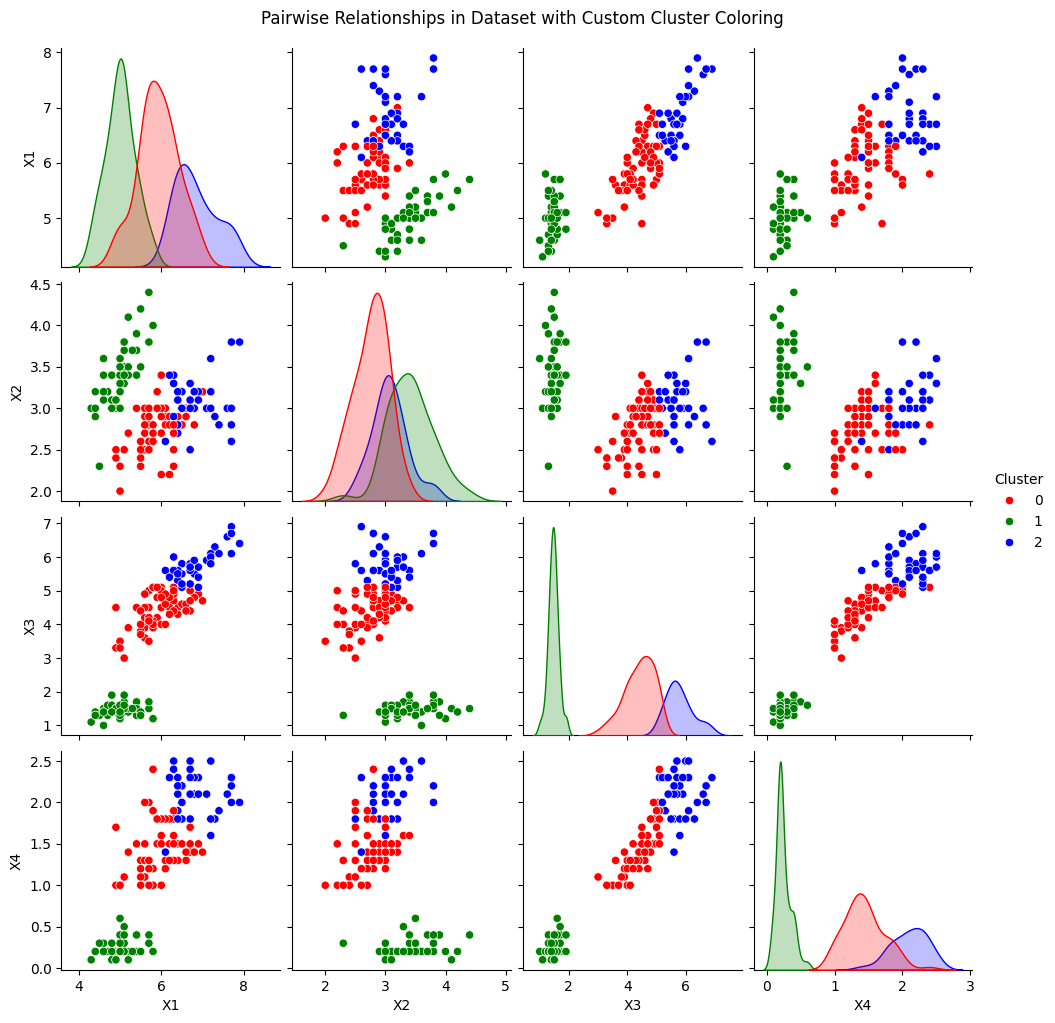

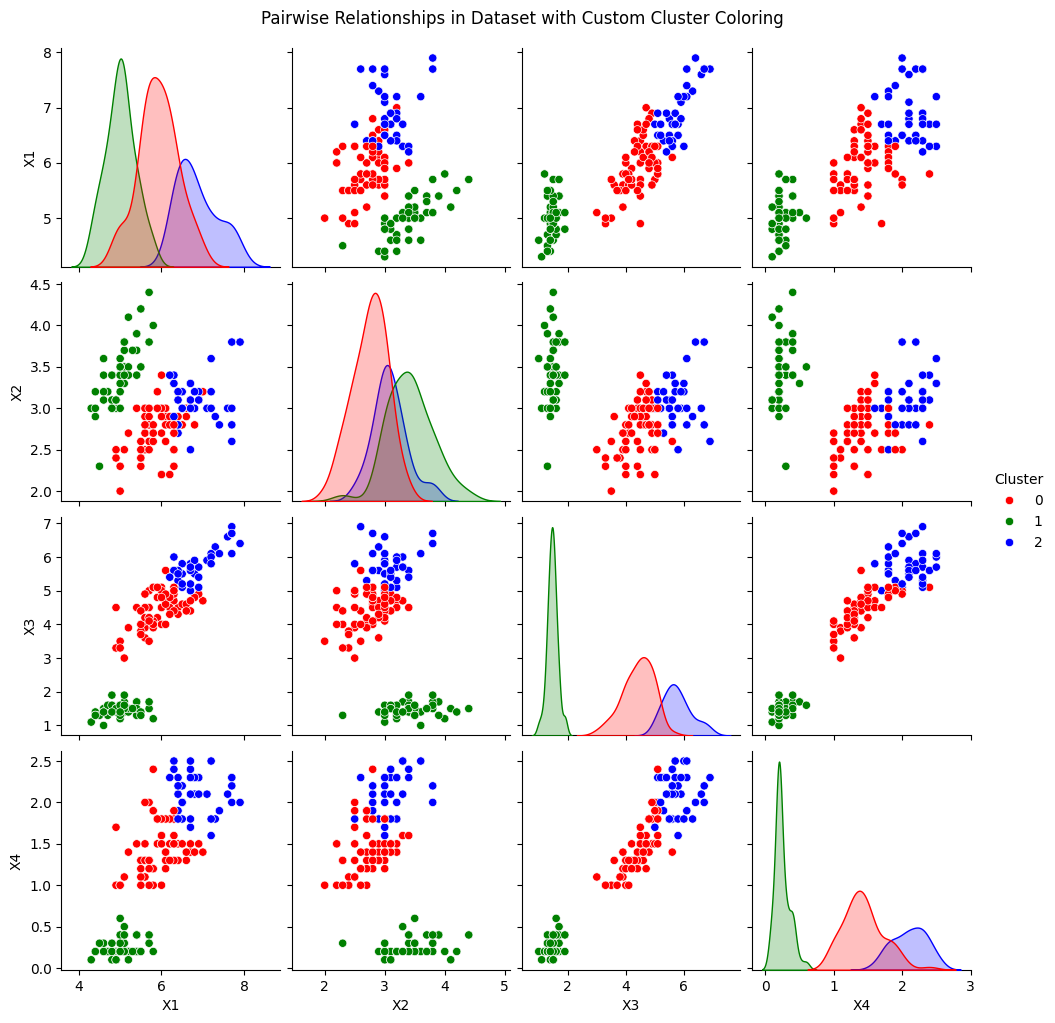

C:\Users\Ardeleanu Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
C:\Users\Ardeleanu Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
C:\Users\Ardeleanu Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_

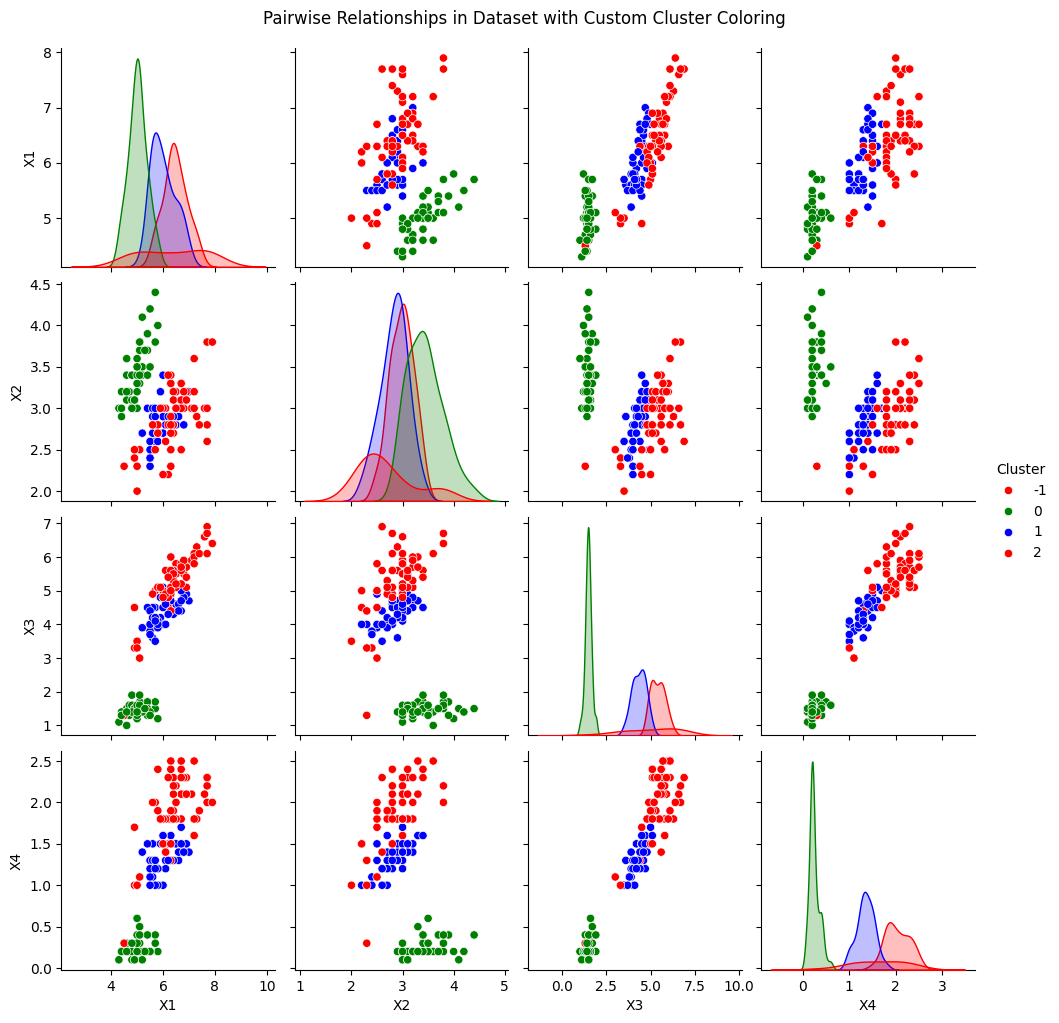

In [ ]:
plot_instances_with_custom_clusters(iris_df, iris_pred_kmeans, "Iris", "Kmeans")
plot_instances_with_custom_clusters(iris_df, iris_pred_em, "Iris", "EM")
plot_instances_with_custom_clusters(iris_df, iris_pred_sl, "Iris", "SingleLink")
plot_instances_with_custom_clusters(iris_df, iris_pred_cl, "Iris", "CompleteLink")
plot_instances_with_custom_clusters(iris_df, iris_pred_al, "Iris", "AverageLink")
plot_instances_with_custom_clusters(iris_df, iris_pred_wl, "Iris", "WardVariance")
plot_instances_with_custom_clusters(iris_df, iris_pred_ds, "Iris", "DBSCAN")

# ARI

In [ ]:
long_truth = long_df['Cluster'].tolist()
iris_truth = iris_df['Cluster'].tolist()
smile_truth = smile_df['Cluster'].tolist()
square_truth = square_df['Cluster'].tolist()
order2_3clust_truth = order2_3clust_df['Cluster'].tolist()
d2_c10_truth = d2_c10_df['Cluster'].tolist()

long_kmeans_ari = adjusted_rand_score(long_truth, long_pred_kmeans)
long_em_ari = adjusted_rand_score(long_truth, long_pred_em)
long_sl_ari = adjusted_rand_score(long_truth, long_pred_sl)
long_cl_ari = adjusted_rand_score(long_truth, long_pred_cl)
long_al_ari = adjusted_rand_score(long_truth, long_pred_al)
long_wl_ari = adjusted_rand_score(long_truth, long_pred_wl)
long_ds_ari = adjusted_rand_score(long_truth, long_pred_ds)
print("\nLong ARI Values:")
print("Kmeans(ARI):", long_kmeans_ari)
print("EM (ARI):", long_em_ari)
print("SingleLink (ARI):", long_sl_ari)
print("CompleteLink(ARI):", long_cl_ari)
print("AverageLink (ARI):", long_al_ari)
print("Ward Variance (ARI):", long_wl_ari)
print("DBSCAN (ARI):", long_ds_ari)
smile_kmeans_ari = adjusted_rand_score(smile_truth, smile_pred_kmeans)
smile_em_ari = adjusted_rand_score(smile_truth, smile_pred_em)
smile_sl_ari = adjusted_rand_score(smile_truth, smile_pred_sl)
smile_cl_ari = adjusted_rand_score(smile_truth, smile_pred_cl)
smile_al_ari = adjusted_rand_score(smile_truth, smile_pred_al)
smile_wl_ari = adjusted_rand_score(smile_truth, smile_pred_wl)
smile_ds_ari = adjusted_rand_score(smile_truth, smile_pred_ds)
print("\nSmile ARI Values:")
print("Kmeans(ARI):", smile_kmeans_ari)
print("EM (ARI):", smile_em_ari)
print("SingleLink (ARI):", smile_sl_ari)
print("CompleteLink(ARI):", smile_cl_ari)
print("AverageLink (ARI):", smile_al_ari)
print("Ward Variance (ARI):", smile_wl_ari)
print("DBSCAN (ARI):", smile_ds_ari)
square_kmeans_ari = adjusted_rand_score(square_truth, square_pred_kmeans)
square_em_ari = adjusted_rand_score(square_truth, square_pred_em)
square_sl_ari = adjusted_rand_score(square_truth, square_pred_sl)
square_cl_ari = adjusted_rand_score(square_truth, square_pred_cl)
square_al_ari = adjusted_rand_score(square_truth, square_pred_al)
square_wl_ari = adjusted_rand_score(square_truth, square_pred_wl)
square_ds_ari = adjusted_rand_score(square_truth, square_pred_ds)
print("\nSquare ARI Values:")
print("Kmeans(ARI):", square_kmeans_ari)
print("EM (ARI):", square_em_ari)
print("SingleLink (ARI):", square_sl_ari)
print("CompleteLink(ARI):", square_cl_ari)
print("AverageLink (ARI):", square_al_ari)
print("Ward Variance (ARI):", square_wl_ari)
print("DBSCAN (ARI):", square_ds_ari)
d2_c10_kmeans_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_kmeans)
d2_c10_em_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_em)
d2_c10_sl_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_sl)
d2_c10_cl_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_cl)
d2_c10_al_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_al)
d2_c10_wl_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_wl)
d2_c10_ds_ari = adjusted_rand_score(d2_c10_truth, d2_c10_pred_ds)
iris_kmeans_ari = adjusted_rand_score(iris_truth, iris_pred_kmeans)
iris_em_ari = adjusted_rand_score(iris_truth, iris_pred_em)
iris_sl_ari = adjusted_rand_score(iris_truth, iris_pred_sl)
iris_cl_ari = adjusted_rand_score(iris_truth, iris_pred_cl)
iris_al_ari = adjusted_rand_score(iris_truth, iris_pred_al)
iris_wl_ari = adjusted_rand_score(iris_truth, iris_pred_wl)
iris_ds_ari = adjusted_rand_score(iris_truth, iris_pred_ds)
print("\nIris ARI Values:")
print("Kmeans(ARI):", iris_kmeans_ari)
print("EM (ARI):", iris_em_ari)
print("SingleLink (ARI):", iris_sl_ari)
print("CompleteLink(ARI):", iris_cl_ari)
print("AverageLink (ARI):", iris_al_ari)
print("Ward Variance (ARI):", iris_wl_ari)
print("DBSCAN (ARI):", iris_ds_ari)
print("\nd2_c10 ARI Values:")
print("Kmeans(ARI):", d2_c10_kmeans_ari)
print("EM (ARI):", d2_c10_em_ari)
print("SingleLink (ARI):", d2_c10_sl_ari)
print("CompleteLink(ARI):", d2_c10_cl_ari)
print("AverageLink (ARI):", d2_c10_al_ari)
print("Ward Variance (ARI):", d2_c10_wl_ari)
print("DBSCAN (ARI):", d2_c10_ds_ari)
order2_3clust_kmeans_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_kmeans)
order2_3clust_em_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_em)
order2_3clust_sl_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_sl)
order2_3clust_cl_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_cl)
order2_3clust_al_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_al)
order2_3clust_wl_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_wl)
order2_3clust_ds_ari = adjusted_rand_score(order2_3clust_truth, order2_3clust_pred_ds)
print("\norder2_3clust ARI Values:")
print("Kmeans(ARI):", order2_3clust_kmeans_ari)
print("EM (ARI):", order2_3clust_em_ari)
print("SingleLink (ARI):", order2_3clust_sl_ari)
print("CompleteLink(ARI):", order2_3clust_cl_ari)
print("AverageLink (ARI):", order2_3clust_al_ari)
print("Ward Variance (ARI):", order2_3clust_wl_ari)
print("DBSCAN (ARI):", order2_3clust_ds_ari)


print("\nBest options for Long: DBSCAN")
print("Best options for Smile: SingleLink | DBSCAN")
print("Best options for Square: DBSCAN")
print("Best options for Iris: EM")
print("Best options for 2d_10c: EM | Ward Variance | DBSCAN")
print("Best options for order2_3clust: EM")





Long ARI Values:
Kmeans(ARI): -0.0008049050857569367
EM (ARI): 0.014894740496765096
SingleLink (ARI): 0.0
CompleteLink(ARI): 0.009077217789808538
AverageLink (ARI): 4.012107820664835e-05
Ward Variance (ARI): 0.00015515831601138952
DBSCAN (ARI): 0.9920199484714934

Smile ARI Values:
Kmeans(ARI): 0.18358283667308023
EM (ARI): 0.192930621447696
SingleLink (ARI): 1.0
CompleteLink(ARI): 0.19059329705918038
AverageLink (ARI): 0.21477856942634743
Ward Variance (ARI): 0.20414654709894994
DBSCAN (ARI): 1.0

Square ARI Values:
Kmeans(ARI): 0.6843405720090815
EM (ARI): 0.6821867797761458
SingleLink (ARI): 1.3507537471235578e-06
CompleteLink(ARI): 0.5504838884994412
AverageLink (ARI): 0.6037435609973467
Ward Variance (ARI): 0.5231640584012696
DBSCAN (ARI): 0.8865864657022973

Iris ARI Values:
Kmeans(ARI): 0.7163421126838476
EM (ARI): 0.9038742317748124
SingleLink (ARI): 0.5637510205230709
CompleteLink(ARI): 0.6422512518362898
AverageLink (ARI): 0.7591987071071522
Ward Variance (ARI): 0.7311985567